In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Column, Integer, String, desc, distinct

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine, reflect = True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measures = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measures.date)).scalar()

In [13]:
# Calculate the date one year from the last date in data set.
prev_year = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=366)
prev_year

datetime.datetime(2016, 8, 22, 0, 0)

In [18]:
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measures.date, Measures.prcp).filter(Measures.date >= prev_year)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
py_df = pd.DataFrame(last_year)
py_df['prcp'] = py_df['prcp'].fillna(0)
# Sort the dataframe by date
py_df = py_df.sort_values(by = 'date', ascending = True)
py_df = py_df.set_index(py_df['date'])
py_df

,date,prcp
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15
...,...,...
2017-08-22,2017-08-22,0.00
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00


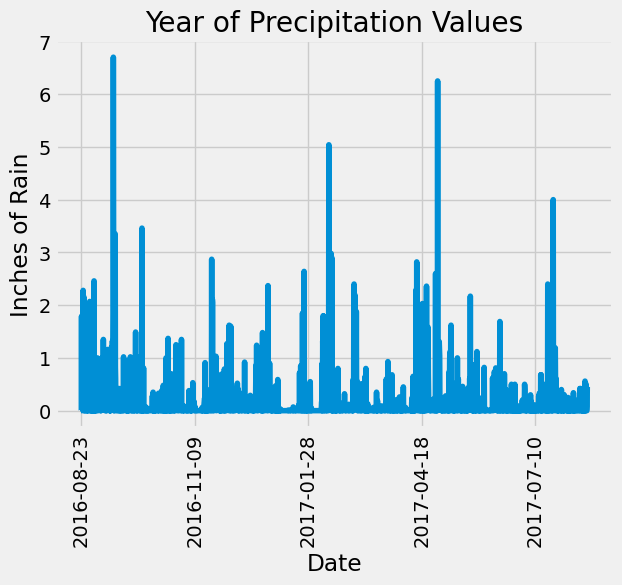

In [19]:
py_df.plot(legend=False)
plt.title('Year of Precipitation Values')
plt.xlabel('Date')
plt.ylabel('Inches of Rain')
plt.xticks(rotation=90)
plt.show()

In [20]:
py_df['prcp'].describe()

count    2230.000000
mean        0.160664
std         0.442067
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
firsts = session.query(Station).first()
firsts.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x27f520dfa90>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [27]:
# List the stations and their counts in descending order.
distinct_counts = session.query(Measures.station, func.count(Measures.station)).\
                  group_by(Measures.station).order_by(desc(func.count(Measures.station))).all()
distinct_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = distinct_counts[0][0]
most_active
ovr_data = session.query(func.min(Measures.tobs), func.max(Measures.tobs), func.avg(Measures.tobs))\
           .filter(Measures.station == most_active).filter(Measures.date >= prev_year).all()
print(f"min:{ovr_data[0][0]}")
print(f"max:{ovr_data[0][1]}")
print(f"avg:{ovr_data[0][2]}")

min:59.0
max:83.0
avg:73.10795454545455


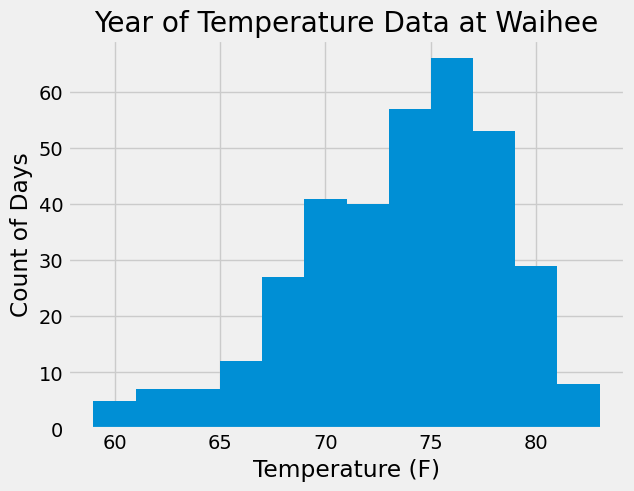

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measures.tobs).filter(Measures.station == most_active).filter(Measures.date >= prev_year).all()
temp_df = pd.DataFrame(temp)
temp_df.plot.hist(bins = 12, legend = False)
plt.title('Year of Temperature Data at Waihee')
plt.ylabel('Count of Days')
plt.xlabel('Temperature (F)')
plt.show()

# Close Session

In [36]:
session.close()